# Outflux from carbonate platform degassing

Another contribution to global carbon desgassing outflux is from carbonate platforms. 

### Dependencies
To run this part, we need:
* to import [`melt`](https://github.com/brmather/melt), a package from a Git repository that implements Katz et al. (2003)'s parameterisation of wet melting. 
* to import [`slabdip`](https://github.com/brmather/Slab-Dip/tree/main); and
* Complete outputs from Notebooks 1, 2 and 6 of `./H2O_review_paper/`; especially the hd5 file outputs.

-------

## How carbonate platform degassing rates are calculated

### H2O Notebooks

We run notebooks 1, 2 and 6 of `./H2O_review_paper/`, which do the following:

* **01 - Sources of water**: We quantify in-plate contained water in Mt/m$^2$/yr for each of the four reservoirs: crust, lithosphere, sediments and serpentinite.
* **02 - Subducted water**: We quantify how much water is subducted from each reservoir, as well as water plate influx. 
* **02 - Maps of water storage**: We calculate H2O wt.% lost at depth using a pressure-temperature look-up table approach. Namely, we use P-T space to determine H2O (wt.%) slab storage flux, then convert it to Mt/m$^2$. We then interpolate water grids from Notebook 01 to trench points to get subduction flux. The remaining water (slab storage) is taken as the minimum between the slab storage and subduction flux:

            # c = component index; 0 for lith, 1 for crust, 2 for sed.
            water_remaining = np.minimum(H2O_component[c], water_interp)
        
    Water subduction flux, slab storage flux and all raw outputs of `slabdip`'s subduction zone statistics are saved to an hd5 file for each timestep.

### This notebook
In this notebook, we read the hd5 files produced in Notebook 6 using `pd.read_hdf()`. The **water outflux rate** is taken to be the difference between the subduction flux rate and slab storage rate (final - initial), calculated in `calc_total_slab_outflux(df)`:

            h2o_slab_outflux = np.clip(subduction_flux - slab_storage, 0, 1e99)
    
**Example:** Based on the methodology for choosing slab storage in notebook 6, in the case where the minimum between the subduction flux and slab storage was the former, then we take slab outflux to be zero.

We combine two gpml files containing carbonate platform polygons, and produce a combined gpml file. The polygons are reconstructed to unique times using `pygplates`.

Trench points are reconstructed at each timestep, and the points with parts of the contoured continent mask within a set threshold distance are filtered through. This is done for all timesteps, but a second search is done to filter through trenches within the set proximity threshold to reconstructed carbonate platform polygons from 460-0Ma.

We develop a melting fraction array using Katz et al. (2003)'s parametrisations in [`melt`](https://github.com/brmather/melt), convert it to a melting rate array, and mask the array using the carbonate-platform-intersecting trenches. 

The melting rate array is scaled to MtC/yr at present day using the ratio of Bekaert et al. [2021] and Fischer et al. [2019]'s estimate of present-day carbonate platform degassing to the obtained model output. This same scaling parameter is multiplied by each timestep's obtained melting rate array through deep time to obtain the model carbonate platform degassing rate (MtC/yr).

Carbonate platform outflux directly contributes to atmospheric carbon influx - we use these outputs in Notebook 05.

In [1]:
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import numpy as np
import pygplates
import ptt
import gplately
import gplately.tools as tools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
import glob, os
import pandas as pd
from slabdip import SlabDipper
from scipy.spatial import cKDTree
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import scipy.ndimage as sn

%matplotlib inline
# plt.style.use('ggplot')

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.0e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# output grid resolution - should be identical to input grid resolution!
spacingX, spacingY = 0.2, 0.2
resX, resY = int(360./0.2 + 1), int(180./0.2 + 1)
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)
lonq, latq = np.meshgrid(lon_grid,lat_grid)

# reconstruction time steps and spacing
min_time = 0
max_time = 1000
timestep_size = 1

# reversed (start at max_time, end at min_time)
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)

save_output_netcdf = True # !! important
save_output_snapshots = False

In [2]:
# Change `folder_name`: a string to name a new sub-folder for a new set of Notebook 4 outputs; 
# useful for keeping track of reruns
folder_name = "Muller22_Apr21"

# Don't change this: directory to input files
output_directory = "./Outputs/{}/Notebook04/".format(folder_name)
os.makedirs(output_directory, exist_ok=True)
os.makedirs(output_directory+"/figures", exist_ok=True)
os.makedirs(output_directory+"/csv", exist_ok=True)

In [3]:
grid_directory = "./Muller2022_InputGrids/"
def defineGridFiles():
    
    #grid_directory = input_directory+"SRGrids/"
    spreadrate_filename = grid_directory+"SpreadingRate/Muller2022_SPREADING_RATE_grid_{:.1f}Ma.nc"
    agegrid_filename = grid_directory+"SeafloorAge/Muller2022_SEAFLOOR_AGE_grid_{:.1f}Ma.nc"
    return agegrid_filename, spreadrate_filename

In [4]:
# Use GPlately's DataServer to get a rotation model, topology features and static polygons
gdownload = gplately.download.DataServer("Muller2022", verbose=False)
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Use GPlately's DataServer to get coastlines and continents
coastlines, continents, COBs = gdownload.get_topology_geometries()
gplot = gplately.PlotTopologies(plate_reconstruction=model, time=0.0, coastlines=coastlines, continents=continents)


## Methodology

### Prepare all input files
First, we prepare the hd5 files containing H2O slab outfluxes from the `./H2O_Review_Paper/` directory.

In [5]:
# Read hd5 files produced from water notebook 06. 
subduction_filename = "./H2O_review_paper/H2O_Review_Bundle/{}/subduction_timesteps/subduction_{:04d}Ma.h5"

quantities = ['min', 'mean', 'max']

def calc_total_slab_outflux(df, quantity):
    """ Calculate the slab outflux
    
    Arguments
    ---------
        df : pandas DataFrame
        
    Returns
    -------
        outflux : array
    """
    subduction_flux = (
        df['subduction_flux_lithosphere_{}'.format(quantity)] + 
        df['subduction_flux_crust_{}'.format(quantity)] + 
        df['subduction_flux_sediment_{}'.format(quantity)]
    )

    slab_storage = (
        df['slab_storage_lithosphere_{}'.format(quantity)] + 
        df['slab_storage_crust_{}'.format(quantity)] + 
        df['slab_storage_sediment_{}'.format(quantity)]
    )
        
    
    # slab outflux must be >= 0
    h2o_slab_outflux = np.clip(subduction_flux - slab_storage, 0, 1e99)
        
    return h2o_slab_outflux


Next, we combine carbonate platform files and form a pygplates FeatureCollection.

In [6]:
H2O_slab_outflux_time = min_time # Take it to be present day

# Carbonate platforms file - this file combines active carbonate platforms from 
# Zahirovic et al. (2022) with Neoproterozoic carbonates. 
platforms_filename_active = "./utils/Zahirovic_etal_2022_mod-ActiveCarbonatePlatforms (1).gpml"
platforms_filename_neoproterozoic = "./utils/NeoproterozoicCarbonate.gpmlz"

platform_filenames = [
    
    platforms_filename_active,
    platforms_filename_neoproterozoic
]
fc = pygplates.FeatureCollection()
for platform_filename in platform_filenames:
    fc.add( pygplates.FeatureCollection(platform_filename) )

from gplately import pygplates

for i, feature in enumerate(fc):
    feature.set_shapefile_attribute('TOAGE', 0)
    FROMAGE, TOAGE = feature.get_valid_time()
    feature.set_valid_time(FROMAGE, 0)


fc.write("./utils/ActiveCarbonatePlatforms_Neoproterozoic-to-Present.gpml")

# updated carbonate platforms file
platforms_filename = "./utils/ActiveCarbonatePlatforms_Neoproterozoic-to-Present.gpml"

# ensure all features have an active time of 0
fc = pygplates.FeatureCollection(platforms_filename)
for feature in fc:
    if feature.get_shapefile_attribute('TOAGE') != 0:
        raise ValueError("TOAGE must be zero for all platforms")
        
# reconstruct platforms
reconstructed_platforms = model.reconstruct(platforms_filename, gplot.time)

In [7]:
# Read H2O outflux data
gplot.time = min_time

df_time = pd.read_hdf(subduction_filename.format(folder_name, int(gplot.time)))

h2o_slab_outflux = np.zeros((len(quantities), len(df_time)))
slab_outflux_area = np.zeros((len(quantities), len(df_time)))

for i, quantity in enumerate(quantities):
    slab_outflux_area[i,:] = calc_total_slab_outflux(df_time, quantity)
    h2o_slab_outflux[i,:] = slab_outflux_area[i,:].T*df_time['vel'] # Mt/m2 -> Mt/m/yr

### Plot carbonate platform polygons at present day

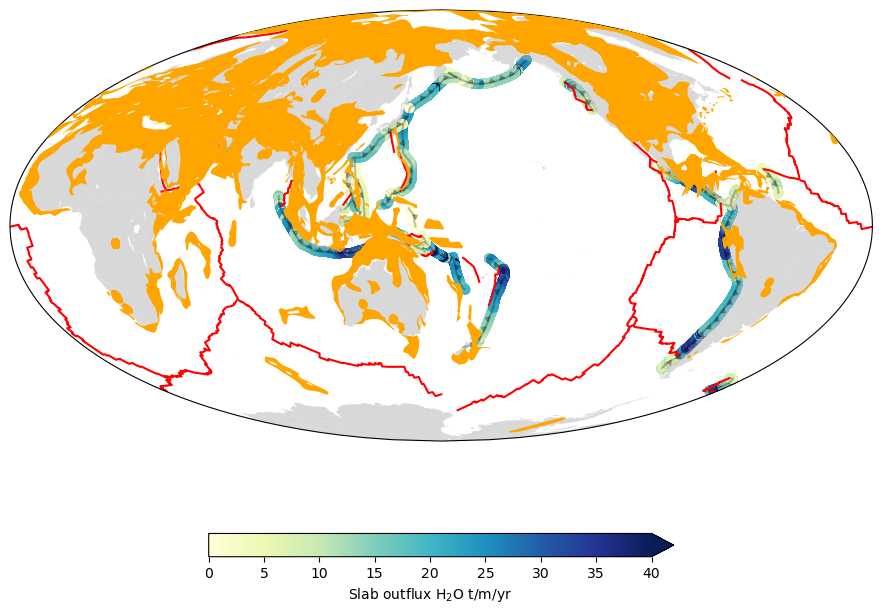

In [9]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=160))
ax.set_global()

gplot.plot_feature(ax, reconstructed_platforms, color='orange', zorder=10)

# plot subduction worms of water outflux
sc = ax.scatter(df_time['lon'], df_time['lat'], c=h2o_slab_outflux[1,:]*1e6,
                cmap='YlGnBu', vmin=0, vmax=40, transform=ccrs.PlateCarree())

gplot.plot_coastlines(ax, color='0.7', alpha=0.5)
gplot.plot_ridges_and_transforms(ax, color='red', linewidth=1.5)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='black', alpha=0.25)
gplot.plot_subduction_teeth(ax, color='black', alpha=0.25)

fig.colorbar(sc, shrink=0.4, orientation='horizontal', extend='max', label='Slab outflux H$_2$O t/m/yr')


### Define auxiliary functions for finding subduction zone intersections


In [9]:
def get_carbonate_platform_coordinates(grid_dir=None, reconstructed_platforms=None, resX=0.2, resY=0.2):
    """
    Allows both grid and pygplates reconstructed platforms.
    Grids carbonate platform and extracts coordinates
    Assumes 0.2 degree resolution by default
    """
    
    nx, ny = int(360/resX), int(180/resY)

    if reconstructed_platforms:
        platforms_grid = rasterize(gplately.geometry.pygplates_to_shapely(reconstructed_platforms),
                                   out_shape=(ny,nx),
                                   transform=from_bounds(-180, 90, 180, -90, nx, ny))
        xq, yq = np.meshgrid(np.linspace(-180,180,nx),
                         np.linspace(-90, 90, ny))
    else:
        # Use mask if available
        platforms_grid  = gplately.Raster(grid_dir, extent=[-180,180,-90,90], resample=(0.2,0.2)).data
        spacingX, spacingY = 360/nx, 180/ny
        xq, yq = np.meshgrid(np.arange(-180,180 + spacingX, spacingX),
                             np.arange(-90, 90 + spacingY, spacingY)) 
    
    mask_grid = platforms_grid > 0
    xcoords = xq[mask_grid]
    ycoords = yq[mask_grid]
    return xcoords, ycoords

def calc_distance_to_trench(plons, plats, lons, lats):
    """
    Calculates the distance to the nearest trench segment
    for given lons and lats
    """
    trench_xyz   = gplately.tools.lonlat2xyz(lons, lats, degrees=True)
    platform_xyz = gplately.tools.lonlat2xyz(plons, plats, degrees=True)
    
    tree = cKDTree(np.c_[platform_xyz])
    dist, index = tree.query(np.c_[trench_xyz])
    dist *= 6371
    return dist

from scipy.spatial import cKDTree
from rasterio.features import rasterize
from rasterio.transform import from_bounds


def get_continent_polygon_coordinates(continent_polygons=None, grid=None, resX=0.2, resY=0.2):
    """
    Grids continents, and extracts coordinates
    Assumes 0.2 degree resolution by default
    """
    
    nx, ny = int(360/resX), int(180/resY)

    if grid:
        platforms_grid = gplately.Raster(grid,
            resample=(resY, resX),
        ).data
        xq, yq = np.meshgrid(np.arange(-180,180+resX,resX),
                             np.arange(-90, 90+resY, resY))
        
    elif continent_polygons:
        platforms_grid = rasterize(gplately.geometry.pygplates_to_shapely(continent_polygons),
                                   out_shape=(ny,nx),
                                   transform=from_bounds(-180, 90, 180, -90, nx, ny))

        xq, yq = np.meshgrid(np.linspace(-180,180,nx),
                             np.linspace(-90, 90, ny))

    mask_grid = platforms_grid > 0
    xcoords = xq[mask_grid]
    ycoords = yq[mask_grid]
    return xcoords, ycoords


# Other functions from attempts to use subduction polarity angle
def KD_dist(lons0, lats0, lons1, lats1):
    """
    Calculate the distance between two sets of lon,lat coordinates
    """
    xyz0 = gplately.tools.lonlat2xyz(lons0, lats0, degrees=True)
    xyz1 = gplately.tools.lonlat2xyz(lons1, lats1, degrees=True)
    
    tree = cKDTree(np.c_[xyz0])
    dist, index = tree.query(np.c_[xyz1])
    dist *= 6371
    return dist


def distance_to_trench_along_polarity_angle(plons, plats, lons, lats, norms, d_tol):
    # detect only carbonate platforms on the overriding plate
    subduction_norm = np.deg2rad(norms)
    
    dlon = 0.1*np.sin(subduction_norm)
    dlat = 0.1*np.cos(subduction_norm)

    distance_to_trench      = KD_dist(plons, plats, lons, lats)
    distance_to_proj_trench = KD_dist(plons, plats, lons+dlon, lats+dlat)

    mask_dist = np.logical_and(distance_to_trench < d_tol, 
                               distance_to_trench > distance_to_proj_trench)
    return mask_dist

## Obtain a scaling parameter from present-day model carbonate platform degassing 

The scaling parameter is found in the following steps:

### 1. Define carbonate platform degassing estimates from Bekaert et al. [2021] and Fischer et al. [2019]

We use these estimates to scale melt rates (Mt/yr) from step (4) to carbonate platform degassing estimates in MtC/yr.

### 2. Estimate H2O slab outflux

Integrate the slab outflux along trench length to get H2O Mt/yr.

### 3. Find carbonate platform - subduction zone intersections

Extract points that lie within a carbonate platform (lons, lats) and find the distance to the subduction zone. Points within 436 km are considered to be arc related ([Zahirovic et al. 2022](https://rmets.onlinelibrary.wiley.com/doi/10.1002/gdj3.146)).

Work out distances from contoured continent polygons to their nearest trench segments using scipy's KDTree, and mask the proportion of segments that are within the tolerance distance of 250, 350, 450km from their corresponding continent segment. Then apply a second KDTree to find continent-intersecting trench segments within 250, 350 and 450km of their corresponding carbonate platforms. Call this mask `mask_dist`. 

### 4. Obtain a melting fraction
Given the H2O slab outflux obtained in step 2, 

2. Convert the area density of H2O area density to H2O wt % by assuming constant density of 3300 kg/m3 and integrate along the arc-depth of 125 km.
3. Estimate melt fraction after [Katz et al. 2003](https://doi.org/10.1029/2002GC000433) using a constant mantle temperature of 1350C and pressure range between 2.5-4.5 GPa.
4. Convert the melt fraction to a melting rate.
5. Mask the array based on the filtered trenches from step 3.

### 5. Get the ratio of (1)/(4) for the scaling parameter

Once we obtain this scaling parameter, we obtain the model carbonate platform degassing rate for all reconstruction times and scale by that parameter.

The 3 steps are outlined below: 

------


# 1. Define carbonate platform degassing estimates from Bekaert et al. [2021] and Fischer et al. [2019]

Here we compute subduction outflux calibrated with the present-day volcanic degassing estimate of **44.1 +/- 16.6 Mt C/yr** comprised of 

1. Volcanic outgassing from Bekaert et al. [2021], estimated at 18.7 +/- 4.3 Mt C/yr (min 14.4, mean 18.7, max 23.0 Mt C/yr) (out of the mean total slab outflux of 48.4 Mt C/yr). 
2. Diffuse outgassing from Fischer et al. [2019] of 25.35 +/- 12.27 Mt C/yr.

An estimated 20-30% of mean subduction outflux by high-temperature volcanic degassing (18.7 +/- 4.3 Mt C/yr) can be attributed to carbonate platform degassing (Aiuppa et al. (2017)).

We thus consider 20% of the mean to be the minimum, 25% to be the mean, and 30% to be the maximum percentage of carbon degassed from carbonate platforms. Therefore,

1.  **Minimum**: $ 0.2 \space \times \space 14.4 = 2.9 \space \text{Mt C/yr}$ 
2.  **Mean**: $ 0.25 \space \times \space 18.7 = 4.7 \space \text{Mt C/yr}$  
3.  **Maximum**: $ 0.30 \space \times \space 23 = 6.9 \space \text{Mt C/yr}$ 

We assume that an estimated 80-100% of mean subduction outflux by diffuse degassing from Fischer et al. [2019] of 25.35 +/- 12.27 Mt C/yr can be attributed to carbonate platform degassing.

4.  **Minimum**: $ 0.8 \space \times \space 13.1 = 10.5 \space \text{Mt C/yr}$ 
5.  **Mean**: $ 0.9 \space \times \space 25.35 = 22.8 \space \text{Mt C/yr}$  
6.  **Maximum**: $ 1.0 \space \times \space 37.62 = 37.6 \space \text{Mt C/yr}$ 

The sum of these two estimates is:

7.  **Minimum**: $ 2.9 + 10.5 \space \times \space = 13.4 \space \text{Mt C/yr}$ 
8.  **Mean**: $ 4.7 + 22.8 \space \times \space = 27.5 \space \text{Mt C/yr}$  
9.  **Maximum**: $ 6.9 + 37.6 \space \times \space = 44.5 \space \text{Mt C/yr}$ 


#### For non-carbonate platform degassing...

10.  **Maximum**: $ 0.8 \space \times \space 23 = 18.4 \space \text{Mt C/yr}$ 
11.  **Mean**: $ 0.75 \space \times \space 18.7 = 14.0 \space \text{Mt C/yr}$  
12.  **Minimum**: $ 0.70 \space \times \space 14.4 = 10.1 \space \text{Mt C/yr}$ 


13.  **Maximum**: $ 0.2 \space \times \space 37.62 = 7.5 \space \text{Mt C/yr}$ 
14.  **Mean**: $ 0.1 \space \times \space 25.35 = 2.5 \space \text{Mt C/yr}$  
15.  **Minimum**: $ 0 \space \times \space 13.1 = 0 \space \text{Mt C/yr}$ 

The sum of these two estimates is:

7.  **Maximum**: $ 18.4 + 7.5 \space \times \space = 25.9 \space \text{Mt C/yr}$ 
8.  **Mean**: $ 14.0 + 2.5 \space \times \space = 16.5 \space \text{Mt C/yr}$  
9.  **Minimum**: $ 10.1 + 0 \space \times \space = 10.1 \space \text{Mt C/yr}$ 

In [14]:
is_carbonate_platform = [
    13.4,
    27.5,
    44.5
]

is_not_carbonate_platform = [
    10.1,
    16.5,
    25.9
]


The total subduction outflux from the Muller 2022 model is:

In [15]:
subduction_outflux_pd = pd.read_csv('./Outputs/{}/Notebook03/csv/03_slab_outflux.csv'.format(folder_name), index_col=0, header=[0,1])
subduction_outflux_pd = subduction_outflux_pd.reindex(index=reconstruction_times)
subduction_outflux = subduction_outflux_pd.loc[:, (['outflux_total'], ['min', 'mean', 'max'])].to_numpy()

print("Minimum: ", subduction_outflux[0][0], " Mt C/yr")
print("Mean: ", subduction_outflux[0][1], " Mt C/yr")
print("Maximum: ", subduction_outflux[0][2], " Mt C/yr")

Minimum:  59.20037416722951  Mt C/yr
Mean:  67.58431525535428  Mt C/yr
Maximum:  77.56196595746128  Mt C/yr


For completeness: the ratio of non-carbonate platform degassng rates (derived above) against the present-day subduction outflux from Notebook 3.

In [16]:
print(is_not_carbonate_platform[0]/subduction_outflux[0][0] )

print(is_not_carbonate_platform[1]/subduction_outflux[0][1])
print(is_not_carbonate_platform[2]/subduction_outflux[0][2])

print("{}% of subduction outflux is not attributable to carbonate platform degassing.".format(is_not_carbonate_platform[1]/subduction_outflux[0][1]*100))

0.17060702980473516
0.24413948617601489
0.333926553824136
24.413948617601488% of subduction outflux is not attributable to carbonate platform degassing.


# 2. Define H2O outflux for all reconstruction times

In [6]:
components = ['crust', 'lithosphere', 'sediment']
quantities = ['min', 'mean', 'max']
    
def get_h2o_slab_outflux(time):
    """ Return slab outfluxes
    
    Arguments
    ---------
        time : reconstruction time, float or int
        
    Returns
    -------
        water_outflux : array of H2O slab outflux
    """
    
    # Store all fluxes in this array - 3 storage reservoirs, 1 timestep, 3 quantities
    water_outflux = np.zeros((3, 1, 3))
    
    # Read hd5 files produced from water notebook 06. 
    # subduction_filename = parent_directory+"H2O_Review_Bundle/{}/subduction_timesteps/subduction_{:04d}Ma.h5"
    df = pd.read_hdf(subduction_filename.format(folder_name, time))
    
    for c, component in enumerate(components):
        for i, quantity in enumerate(quantities):
            
            subduction_flux = (
                df['subduction_flux_{}_{}'.format(component, quantity)]  
            )
    
            slab_storage = (
                df['slab_storage_{}_{}'.format(component, quantity)]  
            )
        
            h2o_slab_outflux = np.sum(np.clip(subduction_flux - slab_storage, 0, 1e99))  
            water_outflux[c,:,i] = h2o_slab_outflux

    return water_outflux


In [7]:
# Reading files can be done without kernel failure using loky backend.
all_h2o_outfluxes = Parallel(n_jobs=-2, verbose=1, backend='loky')(
    delayed(get_h2o_slab_outflux)(time) for time in reconstruction_times)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  2.1min finished


In [8]:
# Extract outputs from the parallelised routine above into numpy array format
all_h2o_outfluxes = np.array(all_h2o_outfluxes, dtype=object)
all_h2o_outflux_components = np.concatenate(all_h2o_outfluxes, axis=1)

In [9]:
all_h2o_outflux_components_conv = all_h2o_outflux_components.astype("float64")

In [10]:
# Prepare smoothed arrays to be saved to a csv
data_out = np.column_stack((
    
    # Crust
    all_h2o_outflux_components_conv[0,:,:],
    
    # Lithosphere
    all_h2o_outflux_components_conv[1,:,:],
    
    # Sediment
    all_h2o_outflux_components_conv[2,:,:],
    
    # Sum of all outfluxes
    np.sum(all_h2o_outflux_components_conv[:,:,0], axis=0),
    np.sum(all_h2o_outflux_components_conv[:,:,1], axis=0),
    np.sum(all_h2o_outflux_components_conv[:,:,2], axis=0),
))

headers = ['crust', 'lithosphere', 'sediments', 'total',]
quantiles = ['min', 'mean', 'max']

index = pd.MultiIndex.from_product([headers, quantiles])

plate_influx_df = pd.DataFrame(list(data_out), columns = index, index=reconstruction_times) 
plate_influx_df.to_csv(output_directory+'/csv/04_h20_outflux.csv'.format(folder_name), index_label='age')

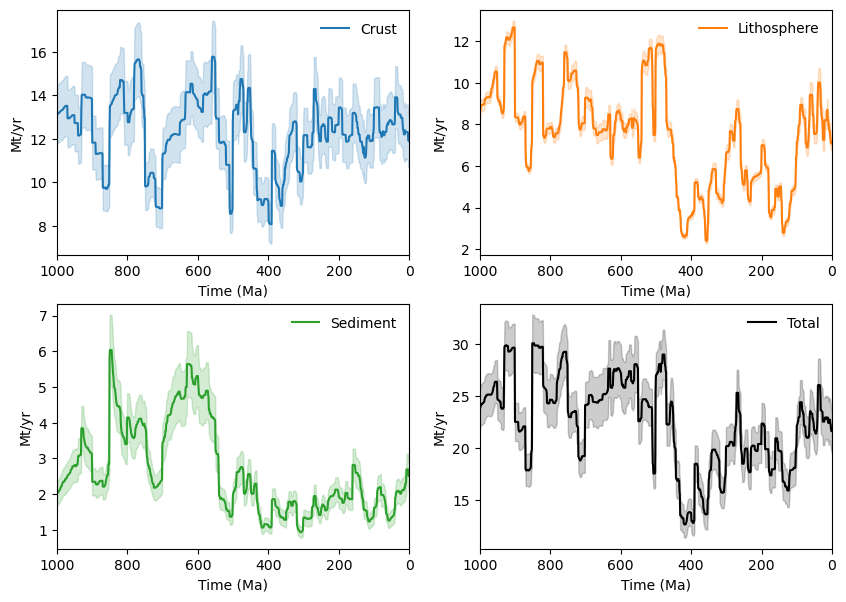

In [11]:
# compare each contribution (separate axes)
time_window = 10 #Myr
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,7))

for c, ax in enumerate([ax1,ax2,ax3,ax4]):
    
    if c == 3:
        min_total_outflux = np.sum(all_h2o_outflux_components_conv[:,:,0], axis=0)
        mean_total_outflux = np.sum(all_h2o_outflux_components_conv[:,:,1], axis=0)
        max_total_outflux = np.sum(all_h2o_outflux_components_conv[:,:,2], axis=0)
        
        ax.fill_between(reconstruction_times,
                    sn.median_filter(min_total_outflux, size=time_window),
                    sn.median_filter(max_total_outflux, size=time_window),
                    color='k', alpha=0.2)
        ax.plot(reconstruction_times, sn.median_filter(mean_total_outflux, size=time_window),
            c="k", label='Total')
        
        ax.set_ylabel("Mt/yr")
        ax.set_xlabel("Time (Ma)")
        ax.set_xlim([1000,0])

        ax.legend(frameon=False)
        continue
    
    
    label = components[c]
    label = label.capitalize()

    ax.fill_between(reconstruction_times,
                    sn.median_filter(all_h2o_outflux_components_conv[c,:,0], size=time_window),
                    sn.median_filter(all_h2o_outflux_components_conv[c,:,2], size=time_window),
                    color='C{}'.format(c), alpha=0.2)
    ax.plot(reconstruction_times, sn.median_filter(all_h2o_outflux_components_conv[c,:,1], size=time_window),
            c="C{}".format(c), label=label)
    
    ax.set_ylabel("Mt/yr")
    ax.set_xlabel("Time (Ma)")
    ax.set_xlim([1000,0])
    
    ax.legend(frameon=False)

plt.savefig(output_directory+"/figures/water_outflux_components.pdf", bbox_inches='tight', dpi=300)
plt.savefig(output_directory+"/figures/water_outflux_components.svg", bbox_inches='tight', dpi=300)
plt.savefig(output_directory+"/figures/water_outflux_components.png", bbox_inches='tight', dpi=300)

# 3. Setup coordinates of continents and carbonate platforms for trench proximity masking

#### From 1000-460Ma...
... We use proximities to continent polygons as a maximum estimate for reconstructed carbonate platform degassing. Original end time for using continents was 541Ma, but due to a lack of carbonate platforms at 540-500Ma, we start at 460Ma instead. For Muller2022, we will use an auxiliary contoured continental netCDF mask without island arcs, by setting `contoured = True` (i.e. use an area buffer around continent polygons) and `use_gpml = False` (i.e. use netCDF masks, not gpml features).

#### From 460-0Ma...
We continue the continent masking, but we add a second kd-tree search for use reconstructed carbonate platform polygons along the trench subduction polarity angle.

-------

For this workflow to work in parallel, we must separate all pygplates reconstruction functions from other functions, and run these using a "threading" backend. For times earlier than 500Ma, we reconstruct Merdith et al. (2021) continent contours by passing through features with the relevant valid times, and for later times, we can normally reconstruct the carbonate platform polygons.

The outputs are the carbonate platform/contoured/non-contoured continent point latitudes and longitudes.

In [22]:
# True for Merdith and Muller, False for Cao and Li.
contoured = True
use_gpml = False

if use_gpml:
    if contoured:
        continents = grid_directory+"ContinentalMasksNoArcs/continent_contour_features.gpmlz"
        cont_fc = gplately.pygplates.FeatureCollection(continents)
    else:
        gplot.continents = continents
        cont_fc = gplot.continents
else:
    cont_fc = grid_directory+"ContinentalMasksNoArcs/continent_mask_{}.0.nc"

In [23]:
def get_carbonate_platform_lat_and_lon(reconstruction_time):
    
    # For times > 460Ma, use contoured continents in place of carbonate platform polygons
    # Current contoured continent gpmlz can just be isolated by valid time.
    # Our gpml file doesn't contain many platforms at 540-500Ma, so start at 460Ma.
    if float(reconstruction_time) > 460.:
        return
    else:
        # We use the carbonate platform polygons and can reconstruct them normally. 
        reconstructed_platforms = model.reconstruct(platforms_filename, reconstruction_time)
    
    plons, plats = get_carbonate_platform_coordinates(reconstructed_platforms=reconstructed_platforms)

    return plons, plats


def get_continent_lat_and_lon(reconstruction_time):
    
    # If we are using contoured continents, these likely come from a large gpmlz file where every
    # feature has already been reconstructed to their valid-time positions already, and we just need to
    # isolate the relevant features by valid-time.
    if use_gpml:
        if contoured is True:

            # THIS IS OUR PREVIOUS METHOD - USING THE GPML CONTOURED CONTINENTS.
            reconstructed_platforms = []
            for cont_feature in cont_fc:
                valid_time = cont_feature.get_valid_time()
                if valid_time[0] < reconstruction_time + 0.51 and valid_time[1] > reconstruction_time - 0.51:
                    reconstructed_platforms.append(cont_feature.get_geometries()[0])

            #cont_grid_dir = "./Muller2022_InputGrids/ContinentalMasks/continent_mask_{}.0.nc".format(reconstruction_time)
            #plons, plats = get_carbonate_platform_coordinates(grid_dir=cont_grid_dir)

        # Otherwise, we can reconstruct the continent polygons normally. Need to use threading backend 
        # because pygplates' reconstruction functions are incompatible with the default loky backend 
        else:
            gplot.time = reconstruction_time
            reconstructed_platforms = gplot.continents
    
        plons, plats = get_carbonate_platform_coordinates(reconstructed_platforms=reconstructed_platforms)
    # If we are not using the gpml (i.e. we are using grids, pass the grid to the rasterise function)
    else:
        plons, plats = get_carbonate_platform_coordinates(grid_dir=cont_fc.format(reconstruction_time))

    return plons, plats

In [24]:
cont_coordinates = Parallel(n_jobs=-2, verbose=1, backend='threading')(
    delayed(get_continent_lat_and_lon)(time) for time in reconstruction_times)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 9 concurrent workers.
/Users/laurenilano/opt/miniconda3/envs/januarytwo/lib/python3.9/site-packages/gplately/grids.py:604: RuntimeWarning: Invalid values encountered in lat; clipping to [-90, 90]
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  2.7min finished


In [25]:
# Extract outputs from the parallelised routine above into numpy array format
cont_coordinates = np.array(cont_coordinates, dtype=object)

all_clons = cont_coordinates[:,0]
all_clats = cont_coordinates[:,1] 

In [26]:
# Only to be run once.
# pygplates feature collections can be used in parallel using a 'threading' backend.
platform_coordinates = Parallel(n_jobs=-2, verbose=1, backend='threading')(
    delayed(get_carbonate_platform_lat_and_lon)(time) for time in reconstruction_times)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 9 concurrent workers.
/Users/laurenilano/opt/miniconda3/envs/januarytwo/lib/python3.9/site-packages/rasterio/features.py:362: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  7.5min finished


In [27]:
# Extract outputs from the parallelised routine above into numpy array format
platform_coordinates = np.array(platform_coordinates, dtype=object)

pcoords = platform_coordinates[0:461]


### Forming uncertainty windows

Uncertainty in model carbonate platform degassing is propagated two ways:
1. From the H2O water outflux;
2. From distance tolerances 250km, 350km and 450km between the continent/carbonate platform and the nearest trench segment.


### Time considerations: 

Take each input continent/carbonate platform latitude and longitude and continue the calculation - read input hd5 files from water notebooks to get H2O outflux, mask trenches within tolerance proximity to our input lats/lons, and get melting rates from melt franctions. The result is the melting rate in Mt/yr. To scale this to MtC/yr, we will obtain the scaling parameter first, then scale all results by this parameter.


# 4. Prepare melt rate lookup table

### Precompute a table of melt fractions
...we use this table to interpolate vales of melt fractions for each trench point through time.

In [28]:
P_range

[2.5, 3, 3.5, 4, 4.5]

In [29]:
# set up discretisation

# Pressure array in GPa
P_range = np.array([2.5, 3, 3.5, 4, 4.5])

# Ranges of bulk water concentration, wt %
X_range = np.arange(0, 0.4, 0.001)

# A 2D array
F_data = np.zeros((P_range.size, X_range.size))

print(F_data.shape, F_data.size)

(5, 400) 2000


In [30]:
# Build the 2D array of melt fractions for a given H2O bulk concentration and pressure. Temperature is constant.
for i, P in enumerate(P_range):
    for j, X in enumerate(X_range):
        F = mlt.F_wet(P, 1350.0, X_range)
        F_data[i,:] = F

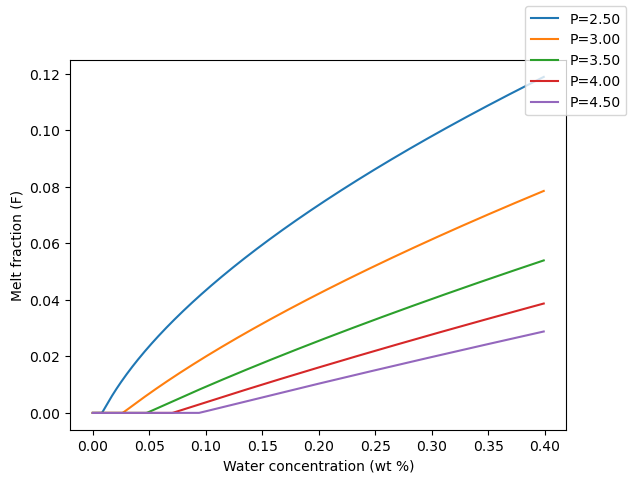

In [31]:
# Visualise the precomputed melt fractions
fig = plt.figure()
ax1 = fig.add_subplot(111, xlabel='Water concentration (wt %)', ylabel='Melt fraction (F)')
for i, P in enumerate(P_range):
    ax1.plot(X_range, F_data[i,:], label='P={:.2f}'.format(P))
    
fig.legend()

### Set up a scipy grid interpolator
This is to interpolate melt fractions for a given trench point.

In [32]:
from scipy.interpolate import RegularGridInterpolator as _RGI
F_interp = _RGI((P_range, X_range), F_data, bounds_error=False)

# Test interpolator
F_test = F_interp((2.5, X_range))

In [10]:
# Minimum, mean and maximum distance tolerances for classifying continental arcs 
# (trench-to-carbonate platform/continent distances that fall below the threshold)
d_tols = [250., 350., 450.]
quantities = ['min', 'mean', 'max']

#d_tols = [450., 350., 250.]
#quantities = ['max','mean', 'min', ]

# We consider three different percentages of carbonate platform degassing rates. 
percentages = [0.15, 0.25, 0.35]


# Combine steps 1-4 into one function

Note that the double k-d tree trench masking is done in here. 

In [34]:
import time

def reconstruct_carbonate_platform_degassing(i, reconstruction_time, quantity, d_tol):
    
    start_time = time.time()
    
    # load subduction data
    df_time = pd.read_hdf(subduction_filename.format(folder_name, reconstruction_time))
    slab_outflux_area = calc_total_slab_outflux(df_time, quantity)

    # Given platform lons and lats, find distances to trench with a kd-tree
    #distance_to_trench = calc_distance_to_trench(df_time, plons, plats)
    #mask_dist = distance_to_trench <= d_tol
    
    lons, lats = df_time['lon'], df_time['lat']
    norms = df_time['norm']
    
    # Get trenches in proximity to continents
    first_mask_dist = distance_to_trench_along_polarity_angle(
        all_clons[i], 
        all_clats[i], 
        lons, lats, norms, d_tol
    )
    
    # Mask all trenches using those in proximity
    in_continent_trench_lons = lons[first_mask_dist]
    in_continent_trench_lats = lats[first_mask_dist]
    in_continent_trench_norms = norms[first_mask_dist]

    # If >499Ma, we can just stop at the continents. 
    if reconstruction_time > 460:
        mask_dist = first_mask_dist
        carb_plat_length = 0
        
    # If <= 499, we have carbonate platform polygons so do a double kd-tree.
    else:

        # Get continent-intersecting-trenches in proximity to carbonate platforms
        mask_dist_within_continent_trench = distance_to_trench_along_polarity_angle(
            pcoords[i][0], 
            pcoords[i][1], 
            in_continent_trench_lons, 
            in_continent_trench_lats, 
            in_continent_trench_norms, d_tol
        )

        # Get new masks as a subset of the original trenches
        mask_dist = np.zeros(len(df_time), dtype=bool)
        mask_dist[first_mask_dist] = mask_dist_within_continent_trench
        
        # Length of trenches intersecting continents and carbonate platforms
        carb_plat_segment_lengths = df_time['length'][mask_dist]
        carb_plat_length = np.sum(carb_plat_segment_lengths)*1e-3 # convert m to km
        

    # Continental arc length is the first mask
    segment_lengths = df_time['length'][first_mask_dist]
    continental_arc_length = np.sum(segment_lengths)*1e-3 # convert m to km

    # convert Mt/m2 -> wt % in the upper 125 km of the asthenospheric mantle (arc depth and above).
    H2O_wt = 100*slab_outflux_area*1e6/(rho_m * d_arc * 1e-3)
    
    # estimate melt fraction
    F = np.zeros(len(df_time))
    for P in P_range:
        #print(P, T_m, H2O_wt.min(), H2O_wt.max())
        # F += mlt.F_wet(P, T_m, H2O_wt)
        F += F_interp((P, H2O_wt))
    F /= len(P_range)
    
    # calculate melting rate (melt fraction is in wt % so we convert to Mt/yr)
    melting_rate = F/100*rho_m*d_arc*df_time['vel']*df_time['length']*1e-9
    melting_rate_platforms = melting_rate[mask_dist].sum()
    carbonate_platform_outflux = melting_rate_platforms
    
    
    #print("--- {}Ma, {} seconds ---".format(reconstruction_time, time.time() - start_time))
    #print(carbonate_platform_outflux, F[mask_dist].mean())
    
    return carbonate_platform_outflux, continental_arc_length, carb_plat_length

# 5. Obtain the present-day scaling parameter to scale melting rate (Mt/yr) to carbonate platform degassing (MtC/yr)
We obtain the present-day carbonate platform degassing rate by running the above function for `time=0`, and comparing the mean value to the rate derived from Bekaert and Fisher:

In [35]:
min_present_day_melting_rate, _, _ = reconstruct_carbonate_platform_degassing(0,0,'min',250) 
mean_present_day_melting_rate, _, _ = reconstruct_carbonate_platform_degassing(0,0,'mean',350) 
max_present_day_melting_rate, _, _ = reconstruct_carbonate_platform_degassing(0,0,'max',450) 

print(min_present_day_melting_rate, mean_present_day_melting_rate, max_present_day_melting_rate)

19.606092467254346 27.42244205143452 36.77281007306792


In [36]:
scaling_parameter = np.floor(is_carbonate_platform[1]/mean_present_day_melting_rate*100)
print("Scaling parameter for mean present day carbonate platform degassing is: {}%.".format(scaling_parameter))

Scaling parameter for mean present day carbonate platform degassing is: 100.0%.


Since it is 1:1, we assume that the scaling parameter between our model carbonate platform degassing and degassing from Bekaert and Fisher is `1`.

In [37]:
%env PYTHONWARNINGS=ignore::RuntimeWarning
import time       
#Generate an array with shape (1001, 3);  1001 for times, and 3 for quantities.
degassing_rates_for_tolerances = np.zeros((len(reconstruction_times), len(d_tols)))
carb_plat_len_for_tolerances = np.zeros((len(reconstruction_times), len(d_tols)))
cont_arc_len_for_tolerances = np.zeros((len(reconstruction_times), len(d_tols)))

start_time = time.time()
for q, quantity in enumerate(quantities):
    
    # At this point, we already have plons and plats from cells above this.
    print("{}...".format(quantity))
    print("For distance tolerance {}km...".format(d_tols[q]))
    print("Scale parameter is {}...".format(scaling_parameter))

    d_tol = d_tols[q]


    # Obtain degassing rates from distance to trench grids - mask these against the d_tol chosen
    #degassing_rates = Parallel(n_jobs=-2, verbose=1, backend='loky') \
    #(delayed(reconstruct_carbonate_platform_degassing) \
    # (t, reconstruction_time, 
    #  quantity,
    #  d_tol
    # ) for t, reconstruction_time in enumerate(reconstruction_times))
    degassing_rates = []
    carbplat_lens = []
    contarc_lens = []
    for t, reconstruction_time in enumerate(reconstruction_times):
        
        degassing_rate, cont_arc_len, carb_plat_len = reconstruct_carbonate_platform_degassing(t, reconstruction_time, quantity, d_tol)
        degassing_rates.append(degassing_rate)
        carbplat_lens.append(carb_plat_len)
        contarc_lens.append(cont_arc_len)
        
        gplately.tools.update_progress(float(t+1)/reconstruction_times.size)
        
    degassing_rates = np.array(degassing_rates)
    
    # Use the 1:1 degassing rate
    degassing_rates_for_tolerances[:,q] = 1 * degassing_rates
    
    carb_plat_len_for_tolerances[:,q] = carbplat_lens
    cont_arc_len_for_tolerances[:,q] = contarc_lens
    
elapsed_time = time.time() - start_time 
print("Time taken: {}".format(elapsed_time))
    

Progress: [####################] 100.0%
Time taken: 3060.02525305748


In [38]:
# Once we have looped through all distance tolerances to obtain min, mean and max degassing rates,
# Scale tiems only from 1000-500Ma to 3 different percentages and save to unique CSV files. 
time_window = 10 # Myr

scaled_degassing_rates_for_tolerances = np.zeros((len(reconstruction_times), len(d_tols)))

for j, percentage in enumerate(percentages):
    
    for t in reconstruction_times:
        # Scale all degassing for times earlier than 460Ma.
        if t >460:
            scaled_degassing_rates_for_tolerances[t,0] = percentage * degassing_rates_for_tolerances[t,0]
            scaled_degassing_rates_for_tolerances[t,1] = percentage * degassing_rates_for_tolerances[t,1]
            scaled_degassing_rates_for_tolerances[t,2] = percentage * degassing_rates_for_tolerances[t,2]
        else:
            
            
            scaled_degassing_rates_for_tolerances[t,0] = degassing_rates_for_tolerances[t,0]
            scaled_degassing_rates_for_tolerances[t,1] = degassing_rates_for_tolerances[t,1]
            scaled_degassing_rates_for_tolerances[t,2] = degassing_rates_for_tolerances[t,2]
    
    min_filtered = sn.median_filter(scaled_degassing_rates_for_tolerances[:,0], size=time_window)
    mean_filtered = sn.median_filter(scaled_degassing_rates_for_tolerances[:,1], size=time_window)
    max_filtered = sn.median_filter(scaled_degassing_rates_for_tolerances[:,2], size=time_window)
    
    data_out = np.column_stack((

        min_filtered, mean_filtered, max_filtered
    ))

    # These values are in Mt/yr
    headers = ['min_carbonate_platform_degassing_rate', 
               'mean_carbonate_platform_degassing_rate',
               'max_carbonate_platform_degassing_rate' ]

    carbon_subducted_df = pd.DataFrame(list(data_out), columns = headers, index=reconstruction_times) 
    carbon_subducted_df.to_csv(
        output_directory+"/csv/carbonate_platform_degassing_{}percent.csv".format(percentage*100)
    )

# Export carb plat lengths
min_cp_length_filtered = sn.median_filter(carb_plat_len_for_tolerances[:,0], size=time_window)
mean_cp_length_filtered = sn.median_filter(carb_plat_len_for_tolerances[:,1], size=time_window)
max_cp_length_filtered = sn.median_filter(carb_plat_len_for_tolerances[:,2], size=time_window)

data_out = np.column_stack((

    min_cp_length_filtered, mean_cp_length_filtered, max_cp_length_filtered
))

# These values are in Mt/yr
headers = ['min_carbonate_platform_length', 
           'mean_carbonate_platform_length',
           'max_carbonate_platform_length' ]

carbon_subducted_df = pd.DataFrame(list(data_out), columns = headers, index=reconstruction_times) 
carbon_subducted_df.to_csv(
    output_directory+"/csv/carbonate_platform_length.csv"
)


# Export cont arc lengths
min_cont_arc_length_filtered = sn.median_filter(cont_arc_len_for_tolerances[:,0], size=time_window)
mean_cont_arc_length_filtered = sn.median_filter(cont_arc_len_for_tolerances[:,1], size=time_window)
max_cont_arc_length_filtered = sn.median_filter(cont_arc_len_for_tolerances[:,2], size=time_window)

data_out = np.column_stack((

    min_cont_arc_length_filtered, mean_cont_arc_length_filtered, max_cont_arc_length_filtered
))

# These values are in Mt/yr
headers = ['min_continental_arc_length', 
           'mean_continental_arc_length',
           'max_continental_arc_length' ]

carbon_subducted_df = pd.DataFrame(list(data_out), columns = headers, index=reconstruction_times) 
carbon_subducted_df.to_csv(
    output_directory+"/csv/continental_arc_length.csv"
)

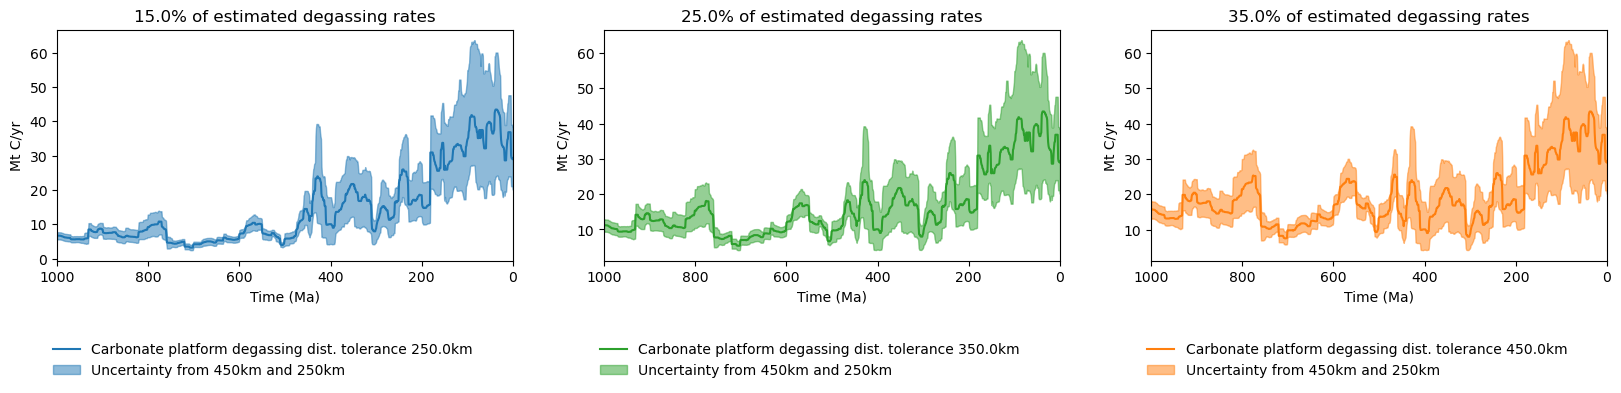

In [11]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,3))

quantities = ["min", "mean", "max"]

colors = ['C0', 'C2', 'C1',]

for c, ax in enumerate([ax1,ax2, ax3]):

    percentage = percentages[c]

    rate_pd = pd.read_csv(
        output_directory+"/csv/carbonate_platform_degassing_{}percent.csv".format(percentage*100),
        index_col=0
    )
    
    headers = ['min_carbonate_platform_degassing_rate', 
               'mean_carbonate_platform_degassing_rate',
               'max_carbonate_platform_degassing_rate' ]
    
    min_scaled_outflux = np.ravel(rate_pd['min_carbonate_platform_degassing_rate'].to_numpy())
    mean_scaled_outflux = np.ravel(rate_pd['mean_carbonate_platform_degassing_rate'].to_numpy())
    max_scaled_outflux = np.ravel(rate_pd['max_carbonate_platform_degassing_rate'].to_numpy())

    ax.plot(
        reconstruction_times, 
        mean_scaled_outflux,
        c=colors[c], label='Carbonate platform degassing dist. tolerance {}km'.format(d_tols[c])
    )
    ax.fill_between(
        reconstruction_times, 
        min_scaled_outflux, 
        max_scaled_outflux, 
        color=colors[c], alpha=0.5, 
        label='Uncertainty from 450km and 250km'
    )

    ax.set_xlim([1000,0])
    ax.legend(frameon=False, bbox_to_anchor=(0.94,-0.3))
    ax.set_ylabel('Mt C/yr')
    ax.set_xlabel('Time (Ma)')

    ax.set_title("{}% of estimated degassing rates".format(percentages[c]*100))
    
plt.savefig(output_directory+"/figures/carbonate_platform_degassing_percentages.pdf", dpi=150, bbox_inches='tight')
plt.savefig(output_directory+"/figures/carbonate_platform_degassing_percentages.svg", dpi=150, bbox_inches='tight')
plt.savefig(output_directory+"/figures/carbonate_platform_degassing_percentages.png", dpi=150, bbox_inches='tight')

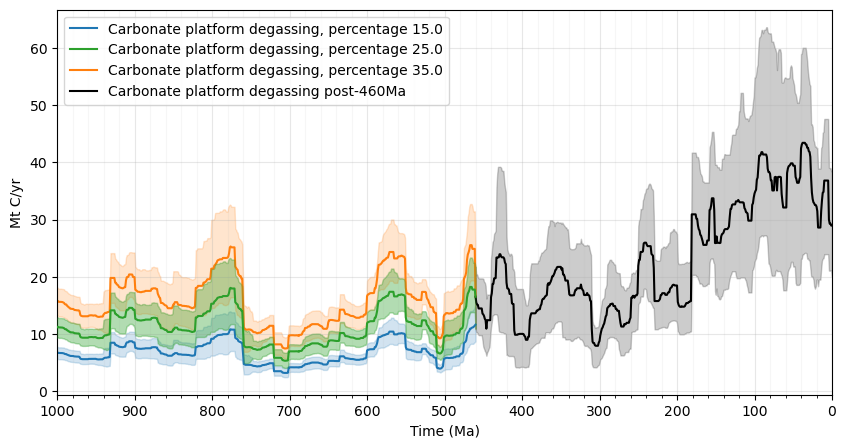

In [8]:
fig, ((ax)) = plt.subplots(1,1, figsize=(10,5))

percentages = [0.15, 0.25, 0.35]

colors = ['C0', 'C2', 'C1',]
for c in [0,1, 2]:

    percentage = percentages[c]
        
    rate_pd = pd.read_csv(
        output_directory+"/csv/carbonate_platform_degassing_{}percent.csv".format(percentage*100),
        index_col=0
    )

    headers = ['min_carbonate_platform_degassing_rate', 
               'mean_carbonate_platform_degassing_rate',
               'max_carbonate_platform_degassing_rate' ]
    
    min_scaled_outflux = np.ravel(rate_pd['min_carbonate_platform_degassing_rate'].to_numpy())
    mean_scaled_outflux = np.ravel(rate_pd['mean_carbonate_platform_degassing_rate'].to_numpy())
    max_scaled_outflux = np.ravel(rate_pd['max_carbonate_platform_degassing_rate'].to_numpy())

    if c == 1:
        ax.plot(
            reconstruction_times[460:], 
            mean_scaled_outflux[460:],
            c=colors[c], 
            label='Carbonate platform degassing, percentage {}'.format(percentage*100),
            zorder=4
        )
        ax.fill_between(
            reconstruction_times[460:], 
            min_scaled_outflux[460:], 
            max_scaled_outflux[460:], 
            color=colors[c], alpha=0.2, 
            zorder=4
            #label='Uncertainty from 450km and 250km, \n percentage {}km'.format(d_tols[c])
        )
    else:
        ax.plot(
            reconstruction_times[460:], 
            mean_scaled_outflux[460:],
            c=colors[c], 
            label='Carbonate platform degassing, percentage {}'.format(percentage*100)
        )
        
    ax.fill_between(
        reconstruction_times[460:], 
        min_scaled_outflux[460:], 
        max_scaled_outflux[460:], 
        color=colors[c], alpha=0.2, 
        #label='Uncertainty from 450km and 250km, \n percentage {}km'.format(d_tols[c])
    )

    
    ax.set_xlim([1000,0])
    ax.legend(frameon=False, loc=2)
    ax.set_ylabel('Mt C/yr')
    ax.set_xlabel('Time (Ma)')
    
# Plot all fluxes from 0-499 in black
ax.plot(
    reconstruction_times[:461], 
    mean_scaled_outflux[:461],
    c='k', 
    label='Carbonate platform degassing post-460Ma')

ax.fill_between(
    reconstruction_times[:461], 
    min_scaled_outflux[:461], 
    max_scaled_outflux[:461], 
    color='k', alpha=0.2, 
    #label='Uncertainty from 450km and 250km, \n percentage {}km'.format(d_tols[c])
)

ax.xaxis.set_ticks(np.arange(0., 1001., 20.), minor=True)
ax.xaxis.set_ticks(np.arange(0., 1001., 100.), major=True)
#ax.yaxis.set_ticks(np.arange(0., 53.01, 2), minor=True)

ax.grid(alpha=0.1, which='both')
ax.grid(alpha=0.3, which='major')

plt.legend(loc='upper left')
    
plt.savefig(output_directory+"/figures/carbonate_platform_degassing_combined_plot.pdf", dpi=150, bbox_inches='tight')
plt.savefig(output_directory+"/figures/carbonate_platform_degassing_combined_plot.svg", dpi=150, bbox_inches='tight')
plt.savefig(output_directory+"/figures/carbonate_platform_degassing_combined_plot.png", dpi=150, bbox_inches='tight')

From 500-0Ma, we use the carbonate platform polygons, and we do not perform percentage scaling. From 1000-500Ma, we use the plate model's continent polygons and perform percentage scaling to account for larger uncertainties in deep time.